# Set up CMS photon jet inference from full python package

## Model setup

Add some details here

In [1]:
import subprocess

from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

import matplotlib.cm as cm
import matplotlib.pyplot as plt

from scipy.linalg import lapack
from scipy import stats
import emcee
import numpy as np

import os
import pickle
from pathlib import Path

import src.reader as Reader

## Step 1: prepare input pickle file

In [2]:
# Read data files
RawData         = Reader.ReadData('input/CMSPhotonJet/Data_CMS_PbPb5020_XJA_0to10.dat')

# Read design points
RawDesign       = Reader.ReadDesign('input/CMSPhotonJet/Design.dat')

# Read model prediction
RawPrediction   = Reader.ReadPrediction('input/CMSPhotonJet/Prediction_CMS_PbPb5020_XJA_0to10.dat')

In [3]:
# Initialize empty dictionary
AllData = {}

# Basic information
AllData["systems"] = ["PbPb5020"]
AllData["keys"] = RawDesign["Parameter"]
AllData["labels"] = RawDesign["Parameter"]
AllData["ranges"] = [(0, 20), (0, 20)]
AllData["observables"] = [('XJA', ["C0"])]

# Data points
Data = {"PbPb5020": {"XJA": {"C0": RawData["Data"]}}}

# Model predictions
Prediction = {"PbPb5020": {"XJA": {"C0": {"Y": RawPrediction["Prediction"], "x": RawData["Data"]['x']}}}}

# Covariance
Covariance = Reader.InitializeCovariance(Data)
Covariance["PbPb5020"][("XJA", "C0")][("XJA", "C0")] = Reader.EstimateCovariance(RawData, RawData, SysLength = {"default": 0.2})

# Assign data to the dictionary
AllData["design"] = RawDesign["Design"]
AllData["model"] = Prediction
AllData["data"] = Data
AllData["cov"] = Covariance

# Save to the desired pickle file
with open('input/default.p', 'wb') as handle:
    pickle.dump(AllData, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [4]:
# Clean past MCMC samples
if os.path.exists('cache/mcmc_chain.hdf'):
    os.remove("cache/mcmc_chain.hdf")

# Clean past emulator
for system in AllData["systems"]:
    if os.path.exists('cache/emulator/' + system + ".pkl"):
        os.remove('cache/emulator/' + system + ".pkl")

In [5]:
RawPrediction["Prediction"].shape

(100, 14)

## Step 2: run emulator

In [6]:
! python3 -m src.emulator --retrain --npc 2 --nrestarts 50

[INFO][emulator] training emulator for system PbPb5020 (2 PC, 50 restarts)
[20 20]
[INFO][emulator] writing cache file cache/emulator/PbPb5020.pkl
PbPb5020
2 PCs explain 0.92171 of variance
GP 0: 0.69417 of variance, LML = 256.96, kernel: 1.87**2 * Matern(length_scale=[22, 23], nu=2.5)
GP 1: 0.22754 of variance, LML = 134.31, kernel: 1.86**2 * Matern(length_scale=[14.8, 11.3], nu=2.5)


## Step 3: MCMC sampling

In [7]:
if os.path.exists('cache/mcmc_chain.hdf'):
    os.remove("cache/mcmc_chain.hdf")
! python3 -m src.mcmc --nwalkers 500 --nburnsteps 2000 3000

[INFO][mcmc] no existing chain found, starting initial burn-in
[INFO][mcmc] running 500 walkers for 1000 steps
[INFO][mcmc] step 100: acceptance fraction: mean 0.6735, std 0.0552, min 0.5200, max 0.8400
[INFO][mcmc] step 200: acceptance fraction: mean 0.6869, std 0.0413, min 0.5550, max 0.8000
[INFO][mcmc] step 300: acceptance fraction: mean 0.6912, std 0.0326, min 0.5967, max 0.7833
[INFO][mcmc] step 400: acceptance fraction: mean 0.6934, std 0.0285, min 0.5975, max 0.7825
[INFO][mcmc] step 500: acceptance fraction: mean 0.6947, std 0.0265, min 0.6080, max 0.7620
[INFO][mcmc] step 600: acceptance fraction: mean 0.6959, std 0.0239, min 0.6133, max 0.7667
[INFO][mcmc] step 700: acceptance fraction: mean 0.6960, std 0.0220, min 0.6214, max 0.7586
[INFO][mcmc] step 800: acceptance fraction: mean 0.6969, std 0.0203, min 0.6238, max 0.7525
[INFO][mcmc] step 900: acceptance fraction: mean 0.6973, std 0.0196, min 0.6300, max 0.7511
[INFO][mcmc] step 1000: acceptance fraction: mean 0.6973, std

## Step 4: Analyze posterior samples

In [8]:
from src import lazydict, emulator
EmulatorPbPb5020 = emulator.Emulator.from_cache('PbPb5020')

In [9]:
import src
src.Initialize()
from src import mcmc
chain = mcmc.Chain()
MCMCSamples = chain.load()

## Step 5: adding all sorts of plots

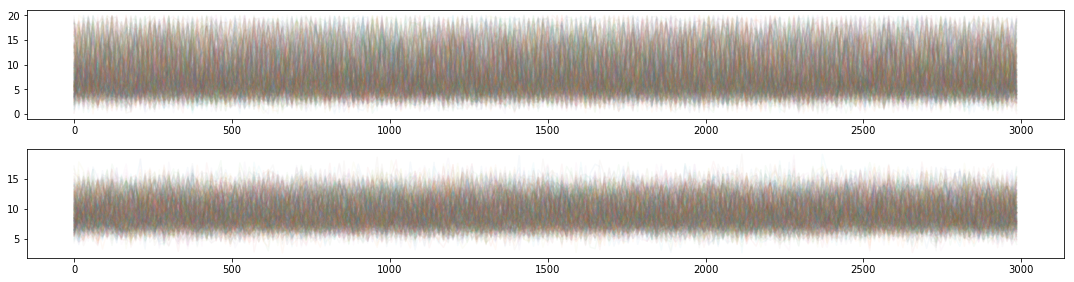

In [10]:
with chain.dataset() as d:
    W = d.shape[0]     # number of walkers
    S = d.shape[1]     # number of steps
    N = d.shape[2]     # number of paramters
    T = int(S / 200)   # "thinning"
    A = 20 / W
    figure, axes = plt.subplots(figsize = (15, 2 * N), ncols = 1, nrows = N)
    for i, ax in enumerate(axes):
        for j in range(0, W):
            ax.plot(range(0, S, T), d[j, ::T, i], alpha = A)
    plt.tight_layout(True)
    plt.savefig('plots/MCMCSamples.pdf', dpi = 192)

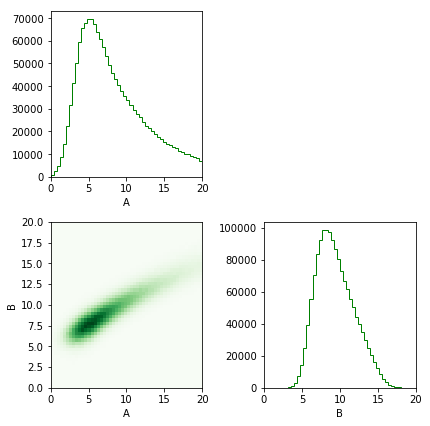

In [11]:
NDimension = len(AllData["labels"])
Ranges = np.array(AllData["ranges"]).T
figure, axes = plt.subplots(figsize = (3 * NDimension, 3 * NDimension), ncols = NDimension, nrows = NDimension)
Names = AllData["labels"]
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        if i==j:
            ax.hist(MCMCSamples[:,i], bins=50,
                    range=Ranges[:,i], histtype='step', color='green')
            ax.set_xlabel(Names[i])
            ax.set_xlim(*Ranges[:,j])
        if i>j:
            ax.hist2d(MCMCSamples[:, j], MCMCSamples[:, i], 
                      bins=50, range=[Ranges[:,j], Ranges[:,i]], 
                      cmap='Greens')
            ax.set_xlabel(Names[j])
            ax.set_ylabel(Names[i])
            ax.set_xlim(*Ranges[:,j])
            ax.set_ylim(*Ranges[:,i])
        if i<j:
            ax.axis('off')
plt.tight_layout(True)
plt.savefig('plots/Correlation.pdf', dpi = 192)
# figure

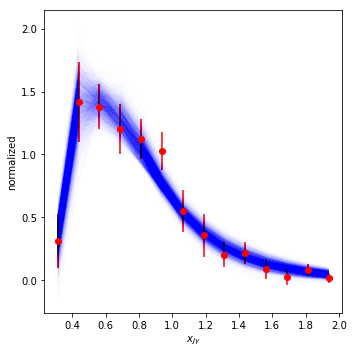

In [12]:
Examples = MCMCSamples[ np.random.choice(range(len(MCMCSamples)), 2500), :]

TempPrediction = {"PbPb5020": EmulatorPbPb5020.predict(Examples)}

figure, axes = plt.subplots(figsize = (5, 5), ncols = 1, nrows = 1)

axes.set_xlabel(r"$x_{J\gamma}$")
axes.set_ylabel(r"normalized")
        
S1 = AllData["systems"][0]
O  = AllData["observables"][0][0]
S2 = AllData["observables"][0][1][0]

DX = AllData["data"][S1][O][S2]['x']
DY = AllData["data"][S1][O][S2]['y']
DE = np.sqrt(AllData["data"][S1][O][S2]['yerr']['stat'][:,0]**2 + AllData["data"][S1][O][S2]['yerr']['sys'][:,0]**2)
                
for i, y in enumerate(TempPrediction[S1][O][S2]):
    axes.plot(DX, y, 'b-', alpha=0.005, label="Posterior" if i==0 else '')
axes.errorbar(DX, DY, yerr = DE, fmt='ro', label="Measurements")

plt.tight_layout(True)
figure.savefig('plots/ObservablePosterior.pdf', dpi = 192)
# figure

In [13]:
# close all plots to save memory
plt.close('all')